In [88]:
#Libraries
import pandas as pd
import numpy as np
#for visualizations
import matplotlib.pyplot as plt

#PyTorch Libraries
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms

from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.datasets import ImageFolder

#image class processing
from PIL import Image

#for progress bar
from tqdm.auto import tqdm



## Objective

The objective of this project is to develop a CDCGAN (Conditional Deep Convolutional GAN) to generate fake images of crashed and intact vehicles to then evaluate whether a GAN augmented dataset can imporve a CNN model

#### Dataset Info:
Crash Car Image Hybrid Dataset (CCIH) 
#### Source:
Kaggle  
#### Author:
Abdulrahman Kerim 
#### Year Published:
2023
#### Data Directories:
- Test
     - Acc (94 image files)
     - Nat (94 image files)
- Train
     - Acc (270 image files)
     - Nat (270 image files)
- Valid
     - Acc (61 image files)
     - Nat (61 image files)
      


## Logic Steps

1. Load data via ImageFolder and DataLoaders
2. Baseline Classifier using CNN
3. Conditional DCGAN
4. GAN Augmented Data
5. Train Augmented Data and compare results

Augmented data training utilizing GAN methods was heavily influenced by Liang Hou study "Augmentation-Aware Self Supervision for Data-Efficient GAN Training". Hou details that training GANS to smaller datasets tend to overfit the data, thus reducing the generatrs ability to learn. Additionally, Hou suggests that AugSelf GANs make GAN models more efficient as they are able to understand the augmentations and transformations more efficiently. We implement some of this methodology by implementing transformations to the initial data before training.

https://papers.nips.cc/paper_files/paper/2023/file/6464638c2472e4cae607f0c96a6fe774-Paper-Conference.pdf

We start by augmenting the data within the training data transforms before any model is built. The transformations that we will be implementing are `.Grayscale`, `.ColorJitter`, `.RandomHorizontalFlip`, and a `.RandomRotation`. The purpose of these augmentations are to help overfitting by creating synthetic versions of the training images and to introduce variation. ColorJitter is later removed because it just clouds up the images. 

No class imbalances exist so class weighting is not necessary as both classes (Accident and Natural) each have 270 cases. If an imbalance were to occur, it would be adviseable to weight losses so the minority class would be more balanced.


In [89]:
file_path = r"C:\Users\Owner\Documents\datsci\Pythonic\archive (2)\CCIH"

#data augmentation for training data
train_transform= transforms.Compose([transforms.ToImage(),
                                     transforms.Grayscale(num_output_channels=1),
                                     transforms.Resize((28,28)),
                                     #transforms.ColorJitter(brightness=[0.5,1.5], #made messy
                                                            #contrast=[0.5,1.5]),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(5),
                                     transforms.ToDtype(torch.float32,scale=True),
                                    ])
val_transform=transforms.Compose([transforms.ToImage(), transforms.Grayscale(num_output_channels=1), transforms.Resize((28,28)), transforms.ToDtype(torch.float32, scale=True),])

test_transform=val_transform
#The way this dataset is, train, validation and test are already split up. This does make it easy to load the data
# additionally, within the file, classes are already identified! They are identified via: 'Acc' and 'Nat' corresponding to accident(crash) and natural(intact)
#train_data
train_dataset = ImageFolder(root=file_path + r"\train",transform=train_transform)
#gan data
gan_train_dataset=ImageFolder(root=file_path + r"\train",transform=val_transform)
#validation data
valid_dataset = ImageFolder(root=file_path + r"\valid", transform=val_transform)
#test data
test_dataset = ImageFolder(root=file_path + r"\test", transform=test_transform)


print("Classes:", train_dataset.classes)
print("Class to index:", train_dataset.class_to_idx)


Classes: ['Acc', 'Nat']
Class to index: {'Acc': 0, 'Nat': 1}


In [90]:
#using a batch size of 32 we utilize a DataLoader to load the data
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
gan_train_loader =DataLoader(gan_train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


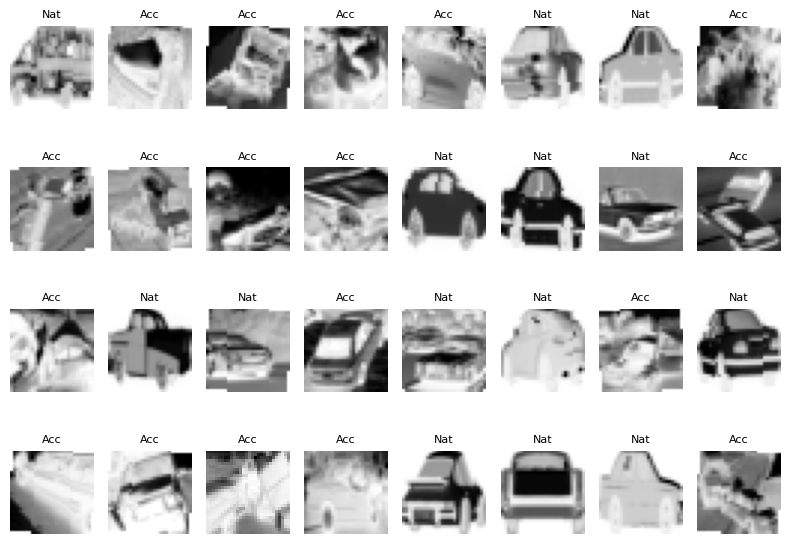

In [91]:
#sanity check to make sure the data loader works
#visual plot

X, y = next(iter(train_loader))

fig, ax = plt.subplots(4, 8, figsize=(8, 6))
ax = ax.flatten()

for i in range(32):
    ax[i].imshow(X[i].numpy().squeeze(), cmap='gray_r')
    label_name = train_dataset.classes[int(y[i])]
    ax[i].set_title(label_name, fontsize=8)
    ax[i].set_axis_off()
plt.tight_layout()


We can definintly see that the transformations did take place and that the Data Loader properly works. This confirms augmentation occured and offers stability to our future network model.

### The DCGAN

First we are going to set the size of our noise vector. Everytime we set the  noise, we draw a sample tensor shape of 100 **(length 100)**. Our noise vector is going to be defined as `latent_dim`. \
In other words, the generator will know that 100 random numbers will be turned into an image of a car. \
We turn our two classes into one hot vectors **(which each have length 2)**:  \
Crash is [1,0] \
Intact is [0,1] \
Our total dimension will be found by concatenating using our classes vector (`total_latent_dim`=102). \


The DCGAN is going to turn a flat vector (here our 102 numbers per image) into a 2D image. Our goal is to end up with a 28x28 image and we will use 2 steps to do so.If every step will double the size, (until we reach 28x28) we should start at 7x7 layers.


The discriminator is going to take the image plus the label maps which equates to 3 channels- where 1 channel is the grayscale image and the two other chanels are crash vs intact. \
For the first convolutional layer:
- 3 input channels
- 64 output (final grayscale image)
- stride=2 (cutting the height and the width in half)
- padding=2
- kernel size= 5x5 \
The ending shape will be (64,14,14) where the feature map is half the width and height \
Next, we apply an activation function via LeakyRELU to introduce nonlinearity; shape stays the same \
After that, we introduce a dropout layer that zeroes out 40% of our activations during the training cycles. This, in turn, helps prevent the discriminator from overpowering the generator. Shape stays the same. \
For the second convolutional layer:
- 64 input channels
- 128 output 
- stride=2
- padding=2
- kernel size= 5x5 \
The ending shape is (128,7,7) which is how the discriminator understands the image \
Next, we apply another LeakyRELU layer and then after that, another Dropout layer. During these two steps, the shape still stays the same. \
Afterwards,we flatten the image which is going to reshape the image into 6272 (which is 7*7*128) \
Finally, after flattening has occured we are ready for the linear layer- where the huge vector of size 6272 is mapped to one output.`nn.Linear` will map the vector to a single scalar value. The mapping that occurs is logit shaped where positive values will influence the discriminator to think the image is real and negative values will influence the discriminator to think the image is fake. The mapping will later be fed into a BCEWithLogitsLoss function. \
The final shape will be 1 since the ultimate goal is a single real or fake image.







In [92]:
latent_dim= 100
num_classes= 2

total_latent_dim= latent_dim + num_classes

#Conditional DCGAN Generator
generator_cnn= nn.Sequential (
    nn.Linear(total_latent_dim, 7*7*128),
    nn.Unflatten(1,(128,7,7)),
    nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128,64, kernel_size=5,padding=2, output_padding=1, stride=2), #7x7 to 14x14
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64,1,kernel_size=5, padding=2, output_padding=1, stride=2),#14x14 to 28x28
    #Sigmoid because we will need either 0 OR 1
    nn.Sigmoid())
#Discriminator
#this is going to take in the input channels
discriminator_cnn=nn.Sequential(
    nn.Conv2d(1+ num_classes,64, kernel_size=5, padding=2, stride=2),
    nn.LeakyReLU(negative_slope=.2),
    #40% dropout
    nn.Dropout(.4),
    nn.Conv2d(64,128, kernel_size=5, padding=2, stride=2),
    nn.LeakyReLU(negative_slope=.2),
    nn.Dropout(.4),
    nn.Flatten(1),
    #final output
    nn.Linear(128*7*7,1))
    

### Conditional GAN Training

We initialize a function for training one epoch. Within this function we utilize the `data_loader` to form the mini batches. The `discriminator` and the `generator` will be using the conditional CNN. the `discriminator_optimizer` will optimize only the discriminator's weights, while the `generator_optimizer` will optimize only the generators weights. As mentioned earlier, the `loss_function` we will be utilizing is `nn.BCEWithLogitsLoss()` which will evaluate the loss of real or fake. Our `latent_dim` is still our noise vector and `num_classes` is still 2. 

After putting the model in training mode, we initialize losses so we can see what the average and total losses are per epoch. We then iterate each mini-batch from the data loader. 

One hot labeling is used to convert to one hot vectors. To concatenate, we cast the int one-hots to floats. Next, the `y_onehot` that gets concatenated with noise is inputed to the generator where its expanded to label maps and concatenated with the image to be sent to the discriminator. 

`unsqueeze(2)` will add a height dimension, and `unsqueeze(3)` will add a width dimension. `expand` will turn the once (1x1) label to have the same height/width as the image (image,2 channels,28x28). The discriminator then receives the image, channels, and labels to ultimately decipher if the image appears to be a crash when its labeled as a crash. 

Once we get to the generator, hopefully, the discriminator is self-training getting better at distinguishing against the reals and fakes. So, to counteract that, wev'e got to train the generator to do better! 

Utilizing new noise samples, we create a new batch of fake images through `gen_fake`. We stack the fake images withe label maps with `gen_fake_input` and we feed that to the discriminator. This time, while we train the generator, we have started to flag the fake images as real (1) in order for the generator to start to produce images that the discriminator believes are real. It sounds counterintuitive but this mechanism nudges the generator to create better outputs by setting the bar higher. 

Next, we initalize `y_gen` to ones and have the discriminator start the process of evaluating the _new fake images_ in `pred_fake`. As the discriminator pushes out 1's for the counterfeit images, the generator, in term gets smarter, outputing more real images through its gradients. For the generator, we use the `zero_grad()` and we backpropagate through the discriminator into the generator while the generator's parameters are updated.



In [93]:
def train_gan_epoch(data_loader,discriminator,generator,discriminator_optimizer,generator_optimizer, loss_function, latent_dim,num_classes):
    #training mode
    discriminator.train()
    generator.train()
    total_d_loss = 0.0
    total_g_loss = 0.0
    total_batches = 0

    #adding progress bar
    pbar = tqdm(data_loader, desc="Training", leave=False)

    #iterate through the mini batches
    for batch in pbar:
        #the real data
        real, labels = batch
        batch_size = len(real)
        total_batches += 1

        #one hot labels
        y_onehot = F.one_hot(labels, num_classes=num_classes).float()
        label_maps = y_onehot.unsqueeze(2).unsqueeze(3).expand(
            -1, -1, real.size(2), real.size(3))

        #Discriminator Training
        #the fake data
        Z = torch.normal(0, 1, size=(batch_size, latent_dim))
        Z_conditional = torch.cat((Z, y_onehot), dim=1)
        fake = generator(Z_conditional)

        real_input = torch.cat((real, label_maps), dim=1)
        fake_input = torch.cat((fake, label_maps), dim=1)

        #labels are 1(real) and 0s fakes
        X_discriminator = torch.cat((real_input, fake_input), dim=0) #dim 0 for the fakes
        y_discriminator = torch.cat(
            (torch.ones(batch_size), torch.zeros(batch_size))).unsqueeze(1)

        #discriminators prediction on the generated X
        pred = discriminator(X_discriminator)
        #Get lossof discriminator
        loss_d= loss_function(pred, y_discriminator)
        discriminator_optimizer.zero_grad()
        #backpropagation step
        loss_d.backward()
        discriminator_optimizer.step()
        total_d_loss += loss_d.item()

        #Now for the generator training
        #Get the generated data and Draw latent codings
        Z = torch.normal(0, 1, size=(batch_size, latent_dim))
        Z_conditional = torch.cat((Z, y_onehot), dim=1)
        gen_fake = generator(Z_conditional)
        gen_fake_input = torch.cat((gen_fake, label_maps), dim=1)

        y_gen = torch.ones(batch_size).unsqueeze(1)
        pred_fake = discriminator(gen_fake_input)
        loss_g = loss_function(pred_fake, y_gen)

        #backpropagation step   but only on the generator parameters
        generator_optimizer.zero_grad()
        loss_g.backward()
        generator_optimizer.step()

        total_g_loss += loss_g.item()

        #progress bar
        pbar.set_postfix({
            "Discriminator Loss": f"{loss_d.item():.3f}",
            "Generator Loss": f"{loss_g.item():.3f}"})

    #average loss per batch
    avg_d_loss = total_d_loss / total_batches
    avg_g_loss = total_g_loss / total_batches
    return total_d_loss, avg_d_loss, total_g_loss, avg_g_loss

In [94]:
#Define the loss functions
loss_function = nn.BCEWithLogitsLoss()

discriminator_optimizer = torch.optim.RMSprop(discriminator_cnn.parameters(),lr=.005, alpha=.9)

generator_optimizer = torch.optim.RMSprop(generator_cnn.parameters(),lr=.001, alpha=.9)

In [95]:
#define the cDCGAN
for epoch in range(10):
    total_d, avg_d, total_g, avg_g = train_gan_epoch(train_loader,discriminator_cnn,generator_cnn,discriminator_optimizer, generator_optimizer,loss_function,latent_dim,num_classes)
    print(f"Epoch {epoch} | discriminator loss={avg_d:.3f} | generator loss={avg_g:.3f}")
#print was created using Copilot

Epoch 0 | discriminator loss=15.853 | generator loss=11.325


Epoch 1 | discriminator loss=0.745 | generator loss=1.717


Epoch 2 | discriminator loss=0.708 | generator loss=1.339


Epoch 3 | discriminator loss=1.813 | generator loss=2.822


Epoch 4 | discriminator loss=0.734 | generator loss=0.863


Epoch 5 | discriminator loss=0.742 | generator loss=0.944


Epoch 6 | discriminator loss=10.677 | generator loss=18.812


Epoch 7 | discriminator loss=0.749 | generator loss=0.792


Epoch 8 | discriminator loss=1.057 | generator loss=1.327


Epoch 9 | discriminator loss=1.324 | generator loss=0.748


Now that we have successfully trained the cDCGAN we can visualize the training data's crash vs intact images and then build the classifier baseline model

To start, we set the generator to **evaluation mode** which is going to help ensure consistent outputs while we sample. Helper function `sample_conditioned_fake_images` generates n samples of fake imagery using the conditional generator. Like before, labels are converted to one hot vectors and shape is going to (16,2) due to the 16 sample size that is selected. Noise is added in `Z` via the `latent_dim=100` and noise is concatenated with the one hot labels. Shape now becomes (16,102).

Next these generated fake images are passed by conditional input through `torch.no_grad()` where gradients aren't tracked. Fake images are the new output with the size (16,1,28,28) and generated images and their labels are printed.

`fake_crash` creates 16 fake images that are conditioned on class 0 (crashed vehicles).

In [96]:

#make sure the generator starts in evaluation mode
generator_cnn.eval()
#this function will use our trained generator to make some fake images
def sample_conditioned_fake_images(generator,class_label, n_samples=16):
    labels = torch.full((n_samples,), class_label, dtype=torch.long)
    y_onehot = F.one_hot(labels, num_classes=num_classes).float()
    #add noise using n_samples and the latent dimension
    Z = torch.normal(0, 1, size=(n_samples, latent_dim))
    #conditional inputs going to be samples, latent dimensions AND the number of classes
    Z_cond = torch.cat((Z, y_onehot), dim=1)
    #fake images using no gradient tracking
    with torch.no_grad():
        fake = generator(Z_cond)
    return fake, labels


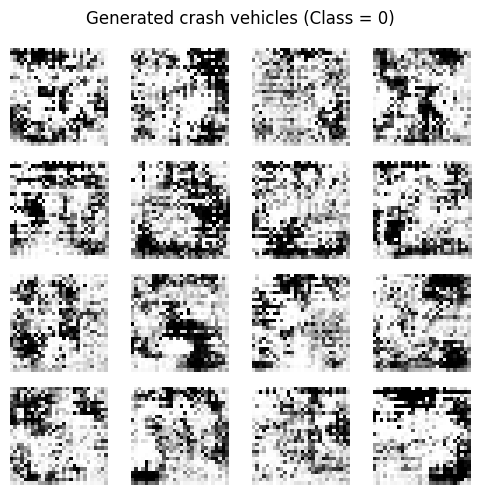

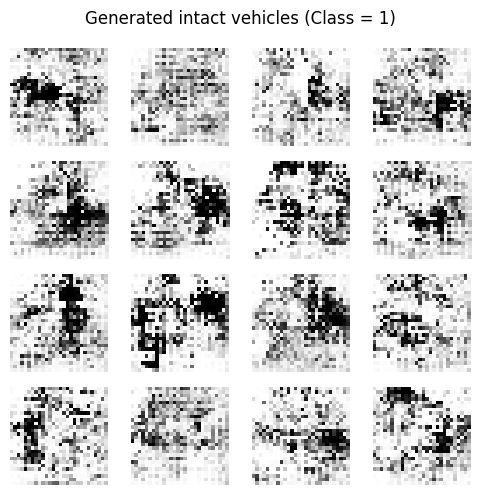

In [97]:
#plot the crashed vehicles class 0
fake_crash, _= sample_conditioned_fake_images(generator_cnn, class_label=0, n_samples=16)

fig, ax = plt.subplots(4, 4,figsize=(5,5))
ax = ax.flatten()
for i in range(16):
    ax[i].imshow(fake_crash[i, 0].detach().numpy(), cmap='gray_r')
    ax[i].set_axis_off()
plt.suptitle("Generated crash vehicles (Class = 0)")#add a super title
plt.tight_layout()
plt.show()
#plot intact class 1 images
fake_intact, _= sample_conditioned_fake_images(generator_cnn, class_label=1, n_samples=16)

fig, ax = plt.subplots(4, 4,figsize=(5,5))
ax = ax.flatten()
for i in range(16):
    ax[i].imshow(fake_intact[i, 0].detach().numpy(), cmap='gray_r')
    ax[i].set_axis_off() #removes axis
plt.suptitle("Generated intact vehicles (Class = 1)")#add a super title
plt.tight_layout()
plt.show()


It's important to note that the genrated images look extremely noisy and lack recognizable structure, which is expected for the smaller epochs and the tiny resolution (28x28). Hence, the synthetic imagery doesn't resmble actual cars so its expected that the GAN isn't going to exhibit peak performance.

## Crash Classifier CNN Model

It is time to use supervised learning to train on the real crash and intact images. The model is going to begin by shrinking the image from (28x28) to (14 x14) then to (7x7). The images are then classified based on crash/intact (0 or 1).

Feature extraction:
- `Conv2d` takes the one channel grayscale image and adds 32 filters and a padding
- `BatchNorm` stabalizes the training and reduces exploding gradients
- `ReLU` allows for the model to take a nonlinear shape
- `MaxPool2d` is going to shrink the image for the first time (14x14)
- the second block repeats the process
- `.classifier` starts the classification block where there is a `Flatten()` (64*7*7)
- `.Linear` will change the size from 3136 to 128
- `ReLu` for more nonlinearity
- `.Linear` where the size goes from 128 to 2 just in time for optimization

In [98]:
#define classifier CNN by training on the  real data
class CrashClassifierCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #28 to 14 (first half)
            nn.MaxPool2d(2),    

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #14 to 7 (second half)
            nn.MaxPool2d(2) )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7,128),
            nn.ReLU(),
            nn.Linear(128,num_classes))

    def forward(self,x):
        x= self.features(x)
        x= self.classifier(x)
        return x


Next we go to training mode and eval mode where the data is ran through epochs. Argmax will the best to determine which class has the highest amount and since we will be measuring accuracy, `argmax` will be used.

In [99]:
#training and eval helper functions
#train
def train_classifier_epoch(data_loader, model, optimizer, loss_fn):
    model.train()
    total_loss= 0.0
    total_correct= 0
    total= 0
    for X, y in data_loader:
        optimizer.zero_grad()
        logits= model(X)
        loss= loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        total_loss+= loss.item() * len(y)
        preds= logits.argmax(dim=1)
        total_correct+= (preds == y).sum().item()
        total+=len(y)
    avg_loss = total_loss / total
    avg_acc = total_correct / total
    return avg_loss, avg_acc

#validation classifier
def eval_classifier_epoch(data_loader, model, loss_fn):
    model.eval()
    total_loss= 0.0
    total_correct= 0
    total= 0

    with torch.no_grad():
        for X, y in data_loader:
            logits= model(X)
            loss= loss_fn(logits,y)

            
            total_loss+= loss.item() *len(y)
            preds= logits.argmax(dim=1)
            total_correct+= (preds== y).sum().item()
            total+= len(y)

    avg_loss= total_loss/total
    avg_acc= total_correct/total
    return avg_loss,avg_acc


Setting our learning rate to .001, we optimize the model using Adam as the optimizer and our `baseline_model` as the input.

In [100]:
#train baseline classifier
baseline_model = CrashClassifierCNN(num_classes=2)
#new loss function
loss_function_ce = nn.CrossEntropyLoss()
optimizer_baseline = torch.optim.Adam(baseline_model.parameters(), lr=.001)

num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc= train_classifier_epoch(train_loader, baseline_model, optimizer_baseline, loss_function_ce)
    valid_loss, valid_acc= eval_classifier_epoch(valid_loader, baseline_model, loss_function_ce)
    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.3f}, train_acc={train_acc:.3f} | "
        f"valid_loss={valid_loss:.3f}, valid_acc={valid_acc:.3f}"
    )
#this print was made using Copilot
# Final test performance:
test_loss, test_acc= eval_classifier_epoch(test_loader, baseline_model,loss_function_ce)
print(f"Baseline test accuracy: {test_acc:.3f}")


Epoch 00 | train_loss=0.362, train_acc=0.833 | valid_loss=0.623, valid_acc=0.713
Epoch 01 | train_loss=0.134, train_acc=0.957 | valid_loss=0.652, valid_acc=0.721
Epoch 02 | train_loss=0.076, train_acc=0.963 | valid_loss=0.624, valid_acc=0.779
Epoch 03 | train_loss=0.056, train_acc=0.978 | valid_loss=0.625, valid_acc=0.803
Epoch 04 | train_loss=0.062, train_acc=0.978 | valid_loss=0.543, valid_acc=0.820
Epoch 05 | train_loss=0.048, train_acc=0.983 | valid_loss=0.846, valid_acc=0.787
Epoch 06 | train_loss=0.032, train_acc=0.989 | valid_loss=0.722, valid_acc=0.811
Epoch 07 | train_loss=0.045, train_acc=0.981 | valid_loss=1.090, valid_acc=0.770
Epoch 08 | train_loss=0.023, train_acc=0.993 | valid_loss=0.918, valid_acc=0.820
Epoch 09 | train_loss=0.014, train_acc=0.994 | valid_loss=0.908, valid_acc=0.795
Baseline test accuracy: 0.606


Now that we have the basseline model-`CrashClassifierCNN` that is training on real images from the `train_loader` we utilize a conditional GAN to generate crash vs intact images with a label. This is going to go beyond a GAN framework to later evaluate an augmented model `aug_model` to see if the classifier evaluates better with the synthetic fake training images from the Gan plus the real ones mixed in, and if it, in turn, gets better at generalizing to test data.

## Training the Conditional GAN

We begin by training the GAN for 25 epochs using `train_gan_epoch` by updating the discriminator and the generator. In this function we track our summed total losses and average losses. The discriminator job is still distinguishing between the real and fakes(discriminator loss), while the generator is learning to trick the denominator(generator loss).

Next these epochs get passed to sample images that are 28x28 grayscale conditioning both the generator and the discriminator on both crash and intact car images-Fake crashes(0) and fake intact cars (1) . Synthetic images are sampled utilizing noise vectors and one hot encoded class labels as they are passed through the trained generator. A plot of snthetic crash and intact images serves as a sanity check that the model leaned classes.

In [101]:
num_epochs = 25  
#changed this up to see augmented cars
for epoch in range(num_epochs):
    total_d, avg_d, total_g, avg_g = train_gan_epoch(
        #train_loader,
        gan_train_loader,
        discriminator_cnn,
        generator_cnn,
        discriminator_optimizer,
        generator_optimizer,
        loss_function,
        latent_dim,
        num_classes
    )

    print(f"Gan Epoch {epoch:02d} | discriminator loss={avg_d:.3f} | generator loss={avg_g:.3f}")
#this print was made using Copilot

Gan Epoch 00 | discriminator loss=2.560 | generator loss=3.396


Gan Epoch 01 | discriminator loss=1.289 | generator loss=1.260


Gan Epoch 02 | discriminator loss=0.767 | generator loss=0.822


Gan Epoch 03 | discriminator loss=5.183 | generator loss=6.085


Gan Epoch 04 | discriminator loss=0.959 | generator loss=0.786


Gan Epoch 05 | discriminator loss=0.734 | generator loss=0.787


Gan Epoch 06 | discriminator loss=5.247 | generator loss=8.282


Gan Epoch 07 | discriminator loss=1.051 | generator loss=0.827


Gan Epoch 08 | discriminator loss=0.717 | generator loss=0.820


Gan Epoch 09 | discriminator loss=1.938 | generator loss=1.101


Gan Epoch 10 | discriminator loss=0.887 | generator loss=1.224


Gan Epoch 11 | discriminator loss=2.644 | generator loss=1.108


Gan Epoch 12 | discriminator loss=0.887 | generator loss=0.994


Gan Epoch 13 | discriminator loss=3.346 | generator loss=3.117


Gan Epoch 14 | discriminator loss=0.830 | generator loss=0.808


Gan Epoch 15 | discriminator loss=0.872 | generator loss=0.882


Gan Epoch 16 | discriminator loss=3.216 | generator loss=2.241


Gan Epoch 17 | discriminator loss=0.727 | generator loss=0.728


Gan Epoch 18 | discriminator loss=0.820 | generator loss=0.940


Gan Epoch 19 | discriminator loss=5.325 | generator loss=3.769


Gan Epoch 20 | discriminator loss=0.776 | generator loss=0.741


Gan Epoch 21 | discriminator loss=0.745 | generator loss=0.785


Gan Epoch 22 | discriminator loss=5.620 | generator loss=5.742


Gan Epoch 23 | discriminator loss=0.769 | generator loss=0.791


Gan Epoch 24 | discriminator loss=0.748 | generator loss=0.765


Text(0.5, 0.98, 'Generated intact (label=1)')

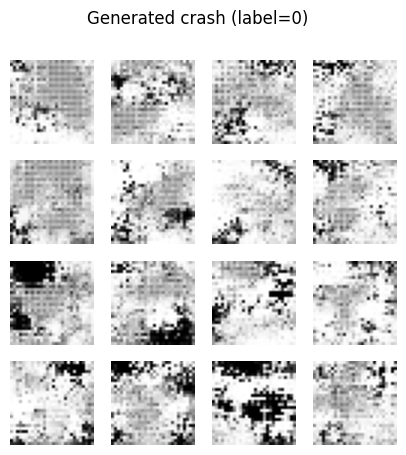

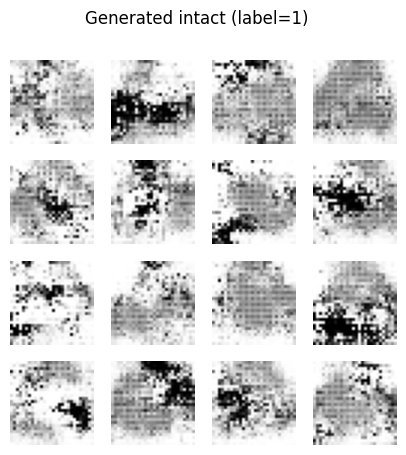

In [102]:
#reuse trained generator cnn and latent dim and num classes to sample some crash vs intact as a sanity checke
def sample_conditioned_fake_images(generator, class_label, n_samples=16):
    #labels all the equal class labels
    labels = torch.full((n_samples,), class_label, dtype=torch.long)
    y_onehot = F.one_hot(labels, num_classes=num_classes).float()
    
    Z = torch.normal(0, 1, size=(n_samples, latent_dim))
    Z_cond = torch.cat((Z, y_onehot), dim=1)
    
    with torch.no_grad():
        fake = generator(Z_cond)   # (n_samples, 1, 28, 28)
    return fake, labels

fake_crash, _  = sample_conditioned_fake_images(generator_cnn, class_label=0, n_samples=16)
fake_intact, _ = sample_conditioned_fake_images(generator_cnn, class_label=1, n_samples=16)

#plot crash vehicles
fig, ax = plt.subplots(4, 4, figsize=(5,5))
ax = ax.flatten()
for i in range(16):
    ax[i].imshow(fake_crash[i,0].detach().numpy(), cmap='gray_r')
    ax[i].set_axis_off()
plt.suptitle("Generated crash (label=0)")

#plot intact vehicles
fig, ax = plt.subplots(4, 4, figsize=(5,5))
ax = ax.flatten()
for i in range(16):
    ax[i].imshow(fake_intact[i,0].detach().numpy(), cmap='gray_r')
    ax[i].set_axis_off()
plt.suptitle("Generated intact (label=1)")

We establish a loader that is batched based to convert the DataLoader into tensors using helper function `as_tensors`. This function loops through batches and concatenates them into `X_real` and `y_real`. In short this should include all the complete real dataset tensor.

In [103]:
#since everything looks good, put the real training set into tensors
#train_loader into X_real, y_real so we can concat fake images a little later

In [104]:
def as_tensors(loader):
    X_list, y_list = [], []
    for X, y in loader:
        X_list.append(X)
        y_list.append(y)
    return torch.cat(X_list), torch.cat(y_list)

X_real, y_real = as_tensors(gan_train_loader)
print("Real train:", X_real.shape, y_real.shape)


Real train: torch.Size([540, 1, 28, 28]) torch.Size([540])


In [105]:
#generate a synthetic dataset using the cDCGAN by generating balanced fake data for each class
def generate_cgan_samples(generator, n_per_class, latent_dim, num_classes=2):
    all_imgs = []
    all_labels = []

    for c in range(num_classes):
        labels= torch.full((n_per_class,), c, dtype=torch.long)
        y_onehot = F.one_hot(labels, num_classes=num_classes).float()
        Z= torch.normal(0, 1, size=(n_per_class, latent_dim))
        Z_cond= torch.cat((Z, y_onehot), dim=1)

        with torch.no_grad():
            fake = generator(Z_cond)

        all_imgs.append(fake)
        all_labels.append(labels)

    X_fake= torch.cat(all_imgs, dim=0)
    y_fake= torch.cat(all_labels, dim=0)
    return X_fake, y_fake

#number of real examples per class
n_real_crash= (y_real== 0).sum().item()
n_real_intact= (y_real== 1).sum().item()
print("Real counts:", n_real_crash, n_real_intact)
#fakes per calss
n_per_class = max(n_real_crash, n_real_intact)
X_fake, y_fake = generate_cgan_samples(generator_cnn, n_per_class=n_per_class,latent_dim=latent_dim,num_classes=num_classes)

print("Fake set:", X_fake.shape, y_fake.shape)

Real counts: 270 270
Fake set: torch.Size([540, 1, 28, 28]) torch.Size([540])


In [106]:
X_aug = torch.cat([X_real, X_fake], dim=0)
y_aug = torch.cat([y_real, y_fake], dim=0)

aug_dataset = TensorDataset(X_aug, y_aug)
aug_loader = DataLoader(aug_dataset, batch_size=32, shuffle=True)

print("Augmented train set:", X_aug.shape, y_aug.shape)


Augmented train set: torch.Size([1080, 1, 28, 28]) torch.Size([1080])


## Final Comparison on the Test Set

In [107]:
#final test baseline vs gan aug
# baseline model

test_loss_base, test_acc_base = eval_classifier_epoch(test_loader, baseline_model, loss_function_ce)
test_loss_aug,  test_acc_aug  = eval_classifier_epoch(test_loader, aug_model,loss_function_ce)

print(f"Baseline Test:    loss={test_loss_base:.3f}, acc={test_acc_base:.3f}")
print(f"GAN-Augmented Test: loss={test_loss_aug:.3f}, acc={test_acc_aug:.3f}")


Baseline Test:    loss=1.781, acc=0.606
GAN-Augmented Test: loss=1.866, acc=0.527


The final model of the conditional DCGAN did not improve classifier perfomance when utilizing the GAN. This could largely be due to the fact that the dataset was small and the images may have been distorted through augmentations. We attempted to raise the number of epochs from 10 to 25, and downgraded some transformations but still received similar results.

All looped and structured print statements were made using the help of Copilot
Functionality was followed using Udemy course: .https://udemy.com/course/generative-adversarial-networks-gans-complete-guide/learn
Youtube channel: www.youtube.com/watch?v=IZtv9s_Wx9I.